In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from os import listdir
import pickle
import string
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model
from numpy import array
from pickle import load
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LSTM, Embedding, Dropout, add
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
if not os.path.exists('/content/drive/MyDrive/DataSets/Flicker/PreprocessedImages/VGG16/features.pickle'):

  def extract_features(directory):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    print(model.summary())
    features = dict()
    for name in tqdm(listdir(directory)):
      filename = directory + '/' + name
      image = load_img(filename, target_size=(224, 224))
      image = img_to_array(image)
      image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      image = preprocess_input(image)
      feature = model.predict(image, verbose=0)
      image_id = name.split('.')[0]
      features[image_id] = feature
    return features

  directory = '/content/drive/MyDrive/DataSets/Flicker/Flickr8k_Dataset/Flicker8k_Dataset'
  features = extract_features(directory)
  print('Extracted Features: %d' % len(features))
  pickle.dump(features, open('/content/drive/MyDrive/DataSets/Flicker/PreprocessedImages/VGG16/features.pickle', 'wb'))

else:
  features = None
  with open('/content/drive/MyDrive/DataSets/Flicker/PreprocessedImages/VGG16/features.pickle', 'rb') as f:
    features = pickle.load(f)

In [ ]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)
 
filename = '/content/drive/MyDrive/DataSets/Flicker/Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)

In [ ]:
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping
 
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)
 
clean_descriptions(descriptions)

In [ ]:
def to_vocabulary(descriptions):
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc
 
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


In [ ]:
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 
save_descriptions(descriptions, '/content/drive/MyDrive/DataSets/Flicker/edited_descriptions.txt')

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

In [ ]:
def load_photo_features(filename, dataset):
	all_features = pickle.load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features

In [ ]:
filename = '/content/drive/MyDrive/DataSets/Flicker/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/DataSets/Flicker/edited_descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
train_features = load_photo_features('/content/drive/MyDrive/DataSets/Flicker/PreprocessedImages/VGG16/features.pickle', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [ ]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


In [ ]:
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	for desc in desc_list:
		seq = tokenizer.texts_to_sequences([desc])[0]
		for i in range(1, len(seq)):
			in_seq, out_seq = seq[:i], seq[i]
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			X1.append(photo)  
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
	while 1:
		for key, desc_list in descriptions.items():
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
			yield [in_img, in_seq], out_word

In [ ]:
def get_max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
max_length = get_max_length(descriptions)

In [ ]:
generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)

In [ ]:
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(47, 4096)
(47, 32)
(47, 7579)


In [ ]:
max_length

32

In [ ]:
def define_model(vocab_size, max_length):
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=0.003))
	#print(model.summary())
	plot_model(model, to_file='/content/drive/MyDrive/Models/Captioner/model.png', show_shapes=True)
	return model

In [ ]:
filename = '/content/drive/MyDrive/DataSets/Flicker/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/DataSets/Flicker/edited_descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
train_features = load_photo_features('/content/drive/MyDrive/DataSets/Flicker/PreprocessedImages/VGG16/features.pickle', train)
print('Photos: train=%d' % len(train_features))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = get_max_length(train_descriptions)
print('Description Length: %d' % max_length)
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


In [ ]:
X1train

array([], dtype=float64)

In [ ]:
filename = '/content/drive/MyDrive/DataSets/Flicker/Flickr8k_text/Flickr_8k.devImages.txt'
dev = load_set(filename)
print('Dataset: %d' % len(dev))
dev_descriptions = load_clean_descriptions('/content/drive/MyDrive/DataSets/Flicker/edited_descriptions.txt', dev)
print('Descriptions: test=%d' % len(dev_descriptions))
dev_features = load_photo_features('/content/drive/MyDrive/DataSets/Flicker/PreprocessedImages/VGG16/features.pickle', dev)
print('Photos: test=%d' % len(dev_features))
X1dev, X2dev, ydev = create_sequences(tokenizer, max_length, dev_descriptions, dev_features, vocab_size)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [ ]:
model = define_model(vocab_size, max_length)

In [ ]:
stop

NameError: ignored

In [ ]:
epochs = 10
steps = len(train_descriptions)
for i in range(epochs):
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	model.save('/content/drive/MyDrive/Models/Captionerrr/model' + str(i) + '.h5')

In [ ]:
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
def generate_desc(model, tokenizer, photo, max_length):
	in_text = 'startseq'
	for i in range(max_length):
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], maxlen=max_length)
		yhat = model.predict([photo,sequence], verbose=0)
		yhat = np.argmax(yhat)
		word = word_for_id(yhat, tokenizer)
		if word is None:
			break
		in_text += ' ' + word
		if word == 'endseq':
			break
	return in_text

In [ ]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	for key, desc_list in tqdm(descriptions.items()):
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())

	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
captioner = define_model(vocab_size, max_length)

In [ ]:
filename = '/content/drive/MyDrive/DataSets/Flicker/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/DataSets/Flicker/edited_descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = get_max_length(train_descriptions)
print('Description Length: %d' % max_length)
 
filename = '/content/drive/MyDrive/DataSets/Flicker/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
test_descriptions = load_clean_descriptions('/content/drive/MyDrive/DataSets/Flicker/edited_descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
test_features = load_photo_features('/content/drive/MyDrive/DataSets/Flicker/PreprocessedImages/VGG16/features.pickle', test)
print('Photos: test=%d' % len(test_features))

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [ ]:
captioner = define_model(vocab_size, max_length)
captioner.load_weights('/content/drive/MyDrive/Models/Captionerrr/model9'+'.h5')

In [ ]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

In [ ]:
len(test)

1000

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


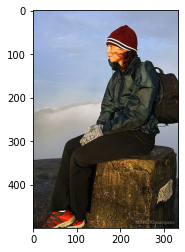

2435685480_a79d42e564.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq girl wearing brown cap red sneakers and dark green coat sits on rock bench 
eq hiker in jacket and knit cap sits with backpack on atop stone with cloudy sky in the background 
eq woman in knit cap and green coat its on stone block looking out 
eq woman with her backpack sits on large rock and looks down over the mountains 
eq the lady is sitting on rock 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


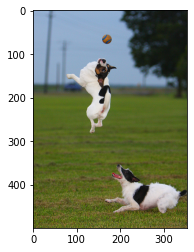

2854959952_3991a385ab.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq one dog leaps to catch softball while another looks on 
eq the two dogs one of which is leaping in the air are chasing ball outdoors 
eq two dogs jump for ball on green field 
eq two dogs play catch with ball in field 
eq two small dogs pursuing ball across grassy field 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


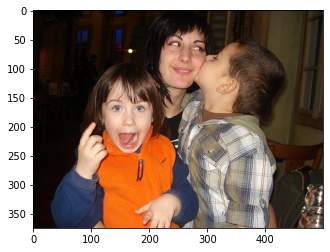

2208310655_a3d83080c5.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq boy is kissing woman on the cheek next to girl who is wide eyed and sticking out her tongue 
eq mother and two children are posing with funny faces 
eq an adult with two kids one child making face and the other kissing the adult cheek 
eq boy kissing woman and girl sticking out her tongue 
eq mother with two boys one acting goofy and the other giving her kiss 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


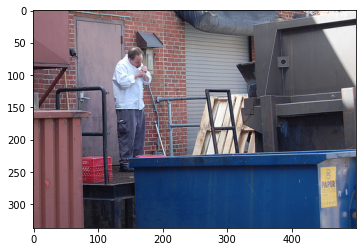

3332467180_d72f9b067d.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq man in white restaraunt shirt smokes next to dumpster 
eq man is lighting smoke outside of building 
eq man lighting cigarette near dumpster in an ally 
eq man lights cigarette on loading dock near dumpster 
eq the man is lighting cigarette outside the back of building 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


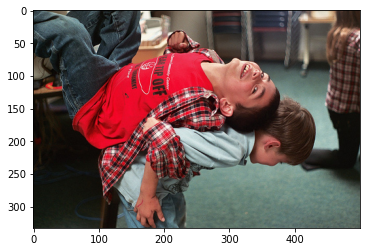

3630332976_fdba22c50b.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq boy pulls other boy over back 
eq one boy hoists another boy up on his back 
eq one child lifts another on his back inside room 
eq the boy in the gray shirt is holding the boy in the red shirt on his back 
eq two boys are back to back as one holds up the other 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


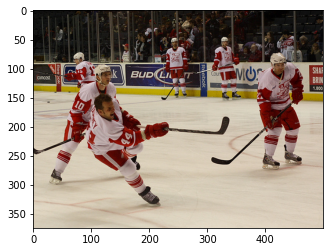

3301811927_a2797339e5.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq group of men playing hockey 
eq team of hockey players with one player taking shot 
eq hockey players with one taking shot 
eq six hockey players of the same team are skating around waiting for the puck 
eq there is an ice hockey game in progress 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


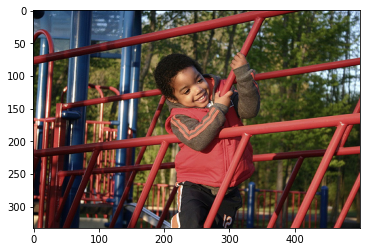

493109089_468e105233.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq little boy in red jacket plays on jungle gym 
eq little boy playing on playground 
eq small black child plays on an outdoor jungle gym 
eq young boy in black sweatshirt and red vest plays on red jungle gym 
eq boy playing on some metal bars 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


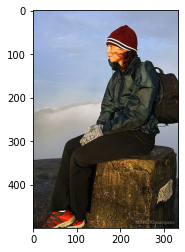

2435685480_a79d42e564.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq girl wearing brown cap red sneakers and dark green coat sits on rock bench 
eq hiker in jacket and knit cap sits with backpack on atop stone with cloudy sky in the background 
eq woman in knit cap and green coat its on stone block looking out 
eq woman with her backpack sits on large rock and looks down over the mountains 
eq the lady is sitting on rock 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


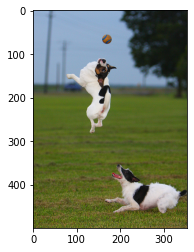

2854959952_3991a385ab.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq one dog leaps to catch softball while another looks on 
eq the two dogs one of which is leaping in the air are chasing ball outdoors 
eq two dogs jump for ball on green field 
eq two dogs play catch with ball in field 
eq two small dogs pursuing ball across grassy field 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


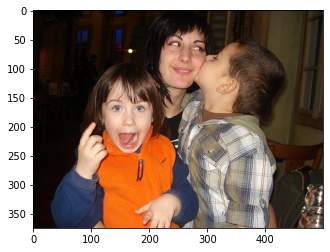

2208310655_a3d83080c5.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq boy is kissing woman on the cheek next to girl who is wide eyed and sticking out her tongue 
eq mother and two children are posing with funny faces 
eq an adult with two kids one child making face and the other kissing the adult cheek 
eq boy kissing woman and girl sticking out her tongue 
eq mother with two boys one acting goofy and the other giving her kiss 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


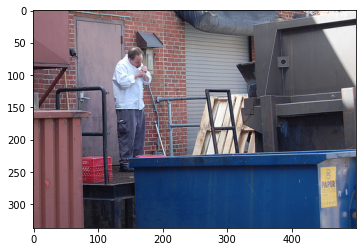

3332467180_d72f9b067d.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq man in white restaraunt shirt smokes next to dumpster 
eq man is lighting smoke outside of building 
eq man lighting cigarette near dumpster in an ally 
eq man lights cigarette on loading dock near dumpster 
eq the man is lighting cigarette outside the back of building 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


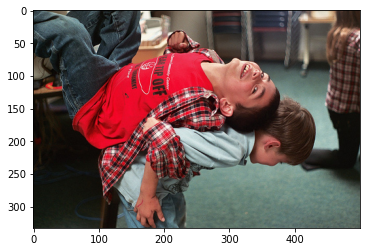

3630332976_fdba22c50b.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq boy pulls other boy over back 
eq one boy hoists another boy up on his back 
eq one child lifts another on his back inside room 
eq the boy in the gray shirt is holding the boy in the red shirt on his back 
eq two boys are back to back as one holds up the other 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


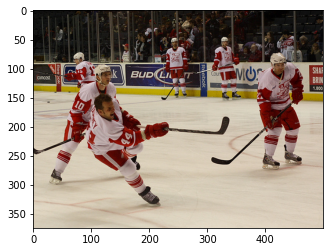

3301811927_a2797339e5.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq group of men playing hockey 
eq team of hockey players with one player taking shot 
eq hockey players with one taking shot 
eq six hockey players of the same team are skating around waiting for the puck 
eq there is an ice hockey game in progress 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


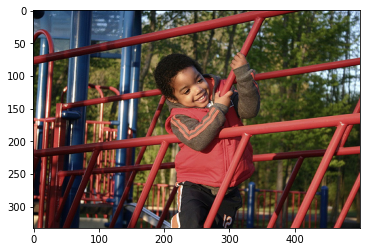

493109089_468e105233.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq little boy in red jacket plays on jungle gym 
eq little boy playing on playground 
eq small black child plays on an outdoor jungle gym 
eq young boy in black sweatshirt and red vest plays on red jungle gym 
eq boy playing on some metal bars 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


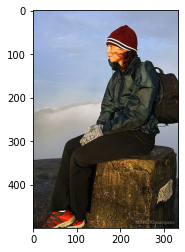

2435685480_a79d42e564.jpg
generated caption:

two dogs are playing with ball

actual_captions:

eq girl wearing brown cap red sneakers and dark green coat sits on rock bench 
eq hiker in jacket and knit cap sits with backpack on atop stone with cloudy sky in the background 
eq woman in knit cap and green coat its on stone block looking out 
eq woman with her backpack sits on large rock and looks down over the mountains 
eq the lady is sitting on rock 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


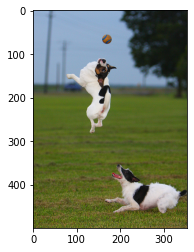

2854959952_3991a385ab.jpg
generated caption:

two dogs are playing with ball

actual_captions:

eq one dog leaps to catch softball while another looks on 
eq the two dogs one of which is leaping in the air are chasing ball outdoors 
eq two dogs jump for ball on green field 
eq two dogs play catch with ball in field 
eq two small dogs pursuing ball across grassy field 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


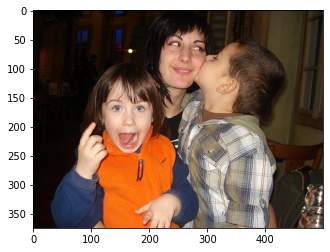

2208310655_a3d83080c5.jpg
generated caption:

two dogs are playing with ball

actual_captions:

eq boy is kissing woman on the cheek next to girl who is wide eyed and sticking out her tongue 
eq mother and two children are posing with funny faces 
eq an adult with two kids one child making face and the other kissing the adult cheek 
eq boy kissing woman and girl sticking out her tongue 
eq mother with two boys one acting goofy and the other giving her kiss 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


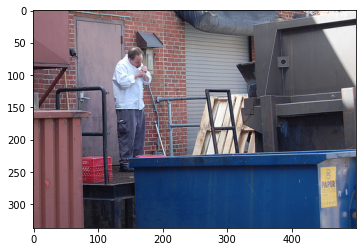

3332467180_d72f9b067d.jpg
generated caption:

two dogs are playing with ball

actual_captions:

eq man in white restaraunt shirt smokes next to dumpster 
eq man is lighting smoke outside of building 
eq man lighting cigarette near dumpster in an ally 
eq man lights cigarette on loading dock near dumpster 
eq the man is lighting cigarette outside the back of building 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


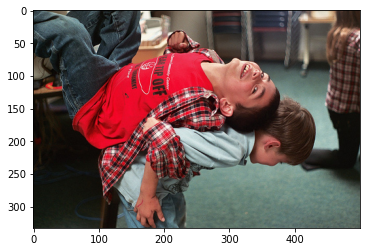

3630332976_fdba22c50b.jpg
generated caption:

two dogs are playing with ball

actual_captions:

eq boy pulls other boy over back 
eq one boy hoists another boy up on his back 
eq one child lifts another on his back inside room 
eq the boy in the gray shirt is holding the boy in the red shirt on his back 
eq two boys are back to back as one holds up the other 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


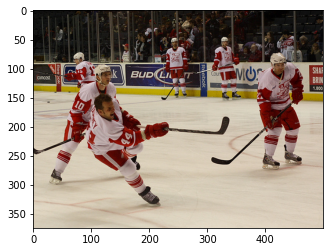

3301811927_a2797339e5.jpg
generated caption:

two dogs are playing with ball

actual_captions:

eq group of men playing hockey 
eq team of hockey players with one player taking shot 
eq hockey players with one taking shot 
eq six hockey players of the same team are skating around waiting for the puck 
eq there is an ice hockey game in progress 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


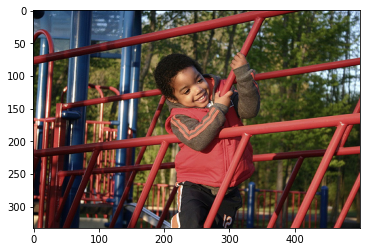

493109089_468e105233.jpg
generated caption:

two dogs are playing with ball

actual_captions:

eq little boy in red jacket plays on jungle gym 
eq little boy playing on playground 
eq small black child plays on an outdoor jungle gym 
eq young boy in black sweatshirt and red vest plays on red jungle gym 
eq boy playing on some metal bars 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


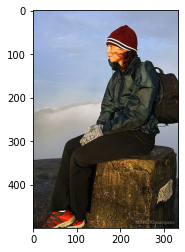

2435685480_a79d42e564.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq girl wearing brown cap red sneakers and dark green coat sits on rock bench 
eq hiker in jacket and knit cap sits with backpack on atop stone with cloudy sky in the background 
eq woman in knit cap and green coat its on stone block looking out 
eq woman with her backpack sits on large rock and looks down over the mountains 
eq the lady is sitting on rock 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


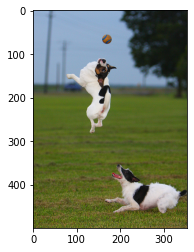

2854959952_3991a385ab.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq one dog leaps to catch softball while another looks on 
eq the two dogs one of which is leaping in the air are chasing ball outdoors 
eq two dogs jump for ball on green field 
eq two dogs play catch with ball in field 
eq two small dogs pursuing ball across grassy field 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


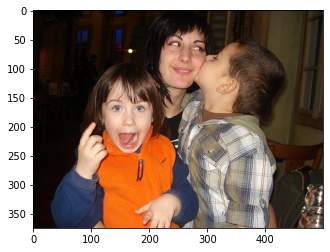

2208310655_a3d83080c5.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq boy is kissing woman on the cheek next to girl who is wide eyed and sticking out her tongue 
eq mother and two children are posing with funny faces 
eq an adult with two kids one child making face and the other kissing the adult cheek 
eq boy kissing woman and girl sticking out her tongue 
eq mother with two boys one acting goofy and the other giving her kiss 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


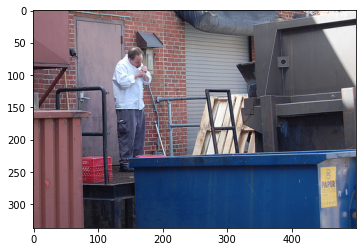

3332467180_d72f9b067d.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq man in white restaraunt shirt smokes next to dumpster 
eq man is lighting smoke outside of building 
eq man lighting cigarette near dumpster in an ally 
eq man lights cigarette on loading dock near dumpster 
eq the man is lighting cigarette outside the back of building 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


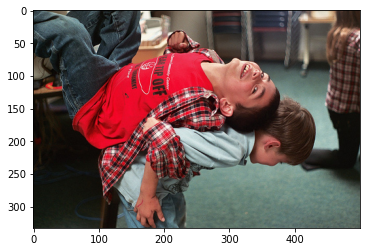

3630332976_fdba22c50b.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq boy pulls other boy over back 
eq one boy hoists another boy up on his back 
eq one child lifts another on his back inside room 
eq the boy in the gray shirt is holding the boy in the red shirt on his back 
eq two boys are back to back as one holds up the other 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


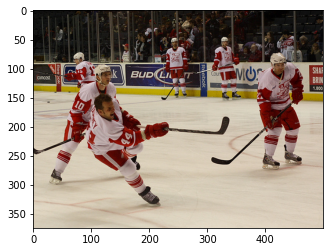

3301811927_a2797339e5.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq group of men playing hockey 
eq team of hockey players with one player taking shot 
eq hockey players with one taking shot 
eq six hockey players of the same team are skating around waiting for the puck 
eq there is an ice hockey game in progress 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


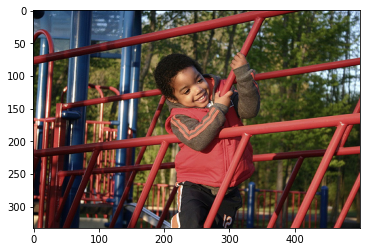

493109089_468e105233.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq little boy in red jacket plays on jungle gym 
eq little boy playing on playground 
eq small black child plays on an outdoor jungle gym 
eq young boy in black sweatshirt and red vest plays on red jungle gym 
eq boy playing on some metal bars 



In [ ]:
for j in range(9,5,-1):
  captioner = define_model(vocab_size, max_length)
  captioner.load_weights('/content/drive/MyDrive/Models/Captionerrr/model{}'.format(j)+'.h5') 
  for i, pic in enumerate(test):
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    pic_name = pic + '.jpg'

    x=plt.imread('/content/drive/MyDrive/DataSets/Flicker/Flickr8k_Dataset/Flicker8k_Dataset/'+ pic_name)
    plt.imshow(x)
    plt.show()
    print(pic_name)
    print('generated caption:\n')
    generated_caption = generate_desc(captioner,tokenizer, test_features[pic],34)
    print(" ".join(generated_caption.split(" ")[1:-1]))
    print()
    print('actual_captions:\n')
    for caption in test_descriptions[pic]:
      print(caption[6:-6])
    print("=====================")
    print("")
    if i > 5:
      break
  

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


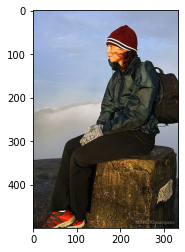

2435685480_a79d42e564.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq girl wearing brown cap red sneakers and dark green coat sits on rock bench 
eq hiker in jacket and knit cap sits with backpack on atop stone with cloudy sky in the background 
eq woman in knit cap and green coat its on stone block looking out 
eq woman with her backpack sits on large rock and looks down over the mountains 
eq the lady is sitting on rock 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


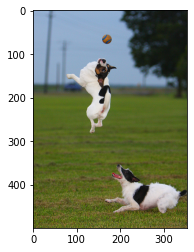

2854959952_3991a385ab.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq one dog leaps to catch softball while another looks on 
eq the two dogs one of which is leaping in the air are chasing ball outdoors 
eq two dogs jump for ball on green field 
eq two dogs play catch with ball in field 
eq two small dogs pursuing ball across grassy field 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


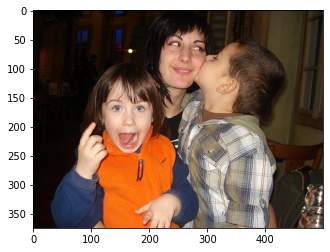

2208310655_a3d83080c5.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq boy is kissing woman on the cheek next to girl who is wide eyed and sticking out her tongue 
eq mother and two children are posing with funny faces 
eq an adult with two kids one child making face and the other kissing the adult cheek 
eq boy kissing woman and girl sticking out her tongue 
eq mother with two boys one acting goofy and the other giving her kiss 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


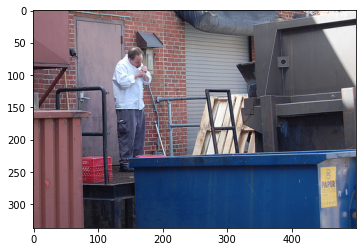

3332467180_d72f9b067d.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq man in white restaraunt shirt smokes next to dumpster 
eq man is lighting smoke outside of building 
eq man lighting cigarette near dumpster in an ally 
eq man lights cigarette on loading dock near dumpster 
eq the man is lighting cigarette outside the back of building 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


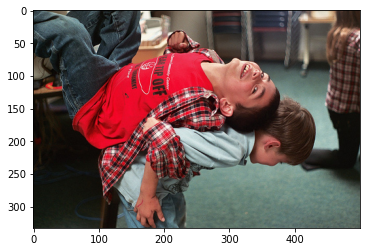

3630332976_fdba22c50b.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq boy pulls other boy over back 
eq one boy hoists another boy up on his back 
eq one child lifts another on his back inside room 
eq the boy in the gray shirt is holding the boy in the red shirt on his back 
eq two boys are back to back as one holds up the other 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


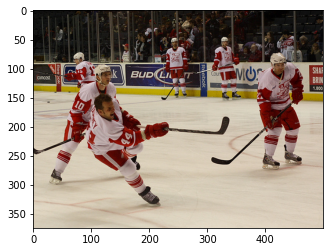

3301811927_a2797339e5.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq group of men playing hockey 
eq team of hockey players with one player taking shot 
eq hockey players with one taking shot 
eq six hockey players of the same team are skating around waiting for the puck 
eq there is an ice hockey game in progress 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


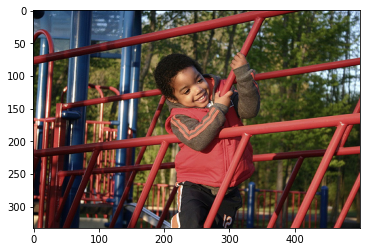

493109089_468e105233.jpg
generated caption:

two dogs are playing in the grass

actual_captions:

eq little boy in red jacket plays on jungle gym 
eq little boy playing on playground 
eq small black child plays on an outdoor jungle gym 
eq young boy in black sweatshirt and red vest plays on red jungle gym 
eq boy playing on some metal bars 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


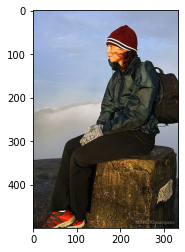

2435685480_a79d42e564.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq girl wearing brown cap red sneakers and dark green coat sits on rock bench 
eq hiker in jacket and knit cap sits with backpack on atop stone with cloudy sky in the background 
eq woman in knit cap and green coat its on stone block looking out 
eq woman with her backpack sits on large rock and looks down over the mountains 
eq the lady is sitting on rock 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


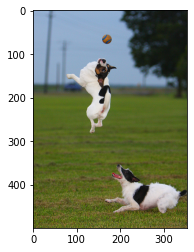

2854959952_3991a385ab.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq one dog leaps to catch softball while another looks on 
eq the two dogs one of which is leaping in the air are chasing ball outdoors 
eq two dogs jump for ball on green field 
eq two dogs play catch with ball in field 
eq two small dogs pursuing ball across grassy field 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


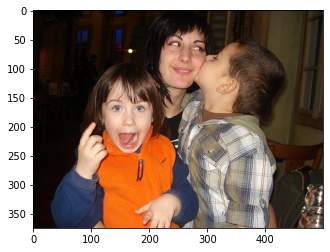

2208310655_a3d83080c5.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq boy is kissing woman on the cheek next to girl who is wide eyed and sticking out her tongue 
eq mother and two children are posing with funny faces 
eq an adult with two kids one child making face and the other kissing the adult cheek 
eq boy kissing woman and girl sticking out her tongue 
eq mother with two boys one acting goofy and the other giving her kiss 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


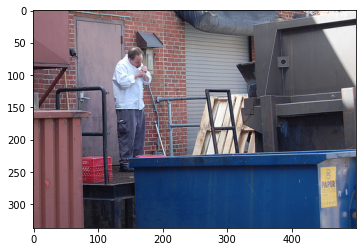

3332467180_d72f9b067d.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq man in white restaraunt shirt smokes next to dumpster 
eq man is lighting smoke outside of building 
eq man lighting cigarette near dumpster in an ally 
eq man lights cigarette on loading dock near dumpster 
eq the man is lighting cigarette outside the back of building 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


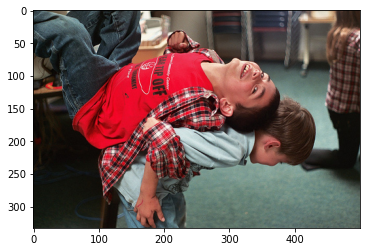

3630332976_fdba22c50b.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq boy pulls other boy over back 
eq one boy hoists another boy up on his back 
eq one child lifts another on his back inside room 
eq the boy in the gray shirt is holding the boy in the red shirt on his back 
eq two boys are back to back as one holds up the other 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


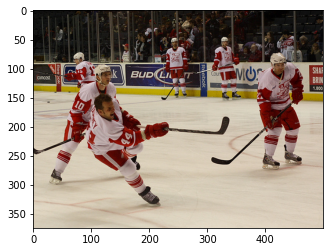

3301811927_a2797339e5.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq group of men playing hockey 
eq team of hockey players with one player taking shot 
eq hockey players with one taking shot 
eq six hockey players of the same team are skating around waiting for the puck 
eq there is an ice hockey game in progress 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


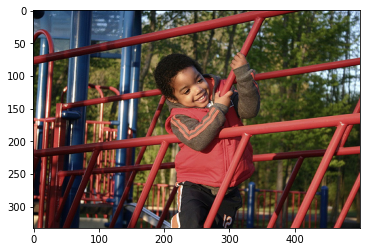

493109089_468e105233.jpg
generated caption:

two dogs are playing in the water

actual_captions:

eq little boy in red jacket plays on jungle gym 
eq little boy playing on playground 
eq small black child plays on an outdoor jungle gym 
eq young boy in black sweatshirt and red vest plays on red jungle gym 
eq boy playing on some metal bars 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


KeyboardInterrupt: ignored

In [ ]:
for j in range(9,5,-1):
  captioner = define_model(vocab_size, max_length)
  captioner.load_weights('/content/drive/MyDrive/Models/Captionerrr/model{}'.format(j)+'.h5') 
  for i, pic in enumerate(test):
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    pic_name = pic + '.jpg'

    x=plt.imread('/content/drive/MyDrive/DataSets/Flicker/Flickr8k_Dataset/Flicker8k_Dataset/'+ pic_name)
    plt.imshow(x)
    plt.show()
    print(pic_name)
    print('generated caption:\n')
    generated_caption = generate_desc(captioner,tokenizer, test_features[pic],34)
    print(" ".join(generated_caption.split(" ")[1:-1]))
    print()
    print('actual_captions:\n')
    for caption in test_descriptions[pic]:
      print(caption[6:-6])
    print("=====================")
    print("")
    if i > 5:
      break
  